# Cleaning data

This notebook shows the process of selecting the subset from the consensus data from the LINCS database

Again, We are analysing the L5 date from LINCS data from
https://github.com/broadinstitute/lincs-cell-painting/tree/master/consensus/2016_04_01_a549_48hr_batch1

The learnings from this notebook are condensed into the utils/clean.py which will be used for later analysis.

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from cytominer_eval import evaluate
from pycytominer.cyto_utils import infer_cp_features
from cytominer_eval.transform import metric_melt

In [23]:
data_dir = '../01_data/2016_04_01_a549_48hr_batch1_consensus_modz_feature_select_dmso.csv.gz'
df = pd.read_csv(data_dir)
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

## Select compounds
First we select a subset of data. For now, we only focus on one concentration of each compound and only include the negative DMSO wells and not the positive controls.
We also only keep compounds that have a known MOAs.
And then we only keep MOAs that have more than one compound.

In [24]:
# 1. Only keep the dose 6 and dose 0 (DMSO)
df = df.query("Metadata_dose_recode == 0 | Metadata_dose_recode == 6 ")
# 2. Get rid of all compounds that have unknown MOAs
df = pd.concat(
 [df.query("Metadata_moa != 'unknown'"),
 df.query("Metadata_broad_sample == 'DMSO'")],
    ignore_index=True
)
# 3. Drop all single Moas
ls = df.Metadata_moa.value_counts() != 1
keys = ls[ls].keys()
df = df[df["Metadata_moa"].isin(keys)]

In [25]:
# check if that made sense
print(df.Metadata_moa.value_counts())
print(df.Metadata_broad_sample.value_counts())
print(df.Metadata_dose_recode.value_counts())

unknown                                                   672
phosphodiesterase inhibitor                                35
adrenergic receptor antagonist                             33
cyclooxygenase inhibitor                                   29
histamine receptor antagonist                              25
                                                         ... 
tyrosinase inhibitor                                        2
lipase inhibitor                                            2
nuclear factor erythroid derived|like (NRF2) activator      2
anthelmintic agent                                          2
L-type calcium channel blocker                              2
Name: Metadata_moa, Length: 235, dtype: int64
DMSO                      672
BRD-K77695569-001-30-0      1
BRD-K73088654-001-01-9      1
BRD-K07857022-002-01-1      1
BRD-K15318383-201-01-5      1
                         ... 
BRD-K64338723-001-01-6      1
BRD-K46018455-001-27-6      1
BRD-K67868012-001-07-6      1
BR

## Selecting features

Next we drop features with very high values. The threshold of 30 was found to be the best.

In [26]:
def drop_feats(df_old, features_old, threshold):
    drop_features = []
    for feat in features_old:
        if (np.abs(df_old[feat]) > threshold).any():
            drop_features.append(feat)
    df_out = df.drop(drop_features,  axis = "columns")
    print("dropped {} features".format(len(drop_features)))
    return df_out, drop_features
df, dropped_feats = drop_feats(df, features, 30)

dropped 27 features


In [16]:
df.to_csv('../01_data/selected_data_df.csv', index=False)

## Appendix
Now we have done all the selection we wanted.
Below are just some double checks.


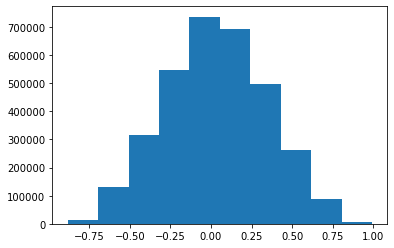

In [34]:
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)
similarity_metric="pearson"
operation="precision_recall"

similarity_melted_df = metric_melt(
            df=df,
            features=features,
            metadata_features=meta_features,
            similarity_metric=similarity_metric,
            eval_metric=operation,
        )
plt.hist(similarity_melted_df.similarity_metric)
plt.show()


Compare this to the plot of the nonselected data and you can see the improvement

## Appendix
Again we check two examples and plot their feature space.

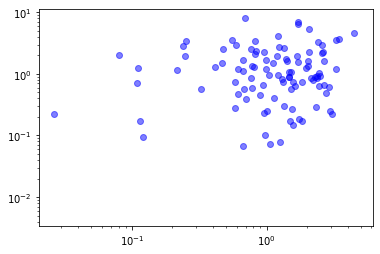

In [10]:
features = infer_cp_features(df)
s1 = "BRD-K21396683-001-04-8"
s2 = "BRD-K51747290-001-13-1"
two = pd.concat([
df.query("Metadata_broad_sample==@s1"),
df.query("Metadata_broad_sample==@s2")
    ], ignore_index=True)
two = two.loc[:, features]
two = two.T
two.columns = ['One','Two']

fig = plt.figure()
ax = plt.gca()
ax.plot(two['One'] ,two['Two'], 'o', c='blue', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [19]:
# this is how to call the util function!

import sys
sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import data_selection as ds

In [22]:
df_1 = pd.read_csv(data_dir)
df_1 = ds.clean_moas(df_1)
df_1 = ds.drop_feats(df_1, 30)

this
dropped 27 features


In [33]:
np.where(df_1 != df)

(array([], dtype=int64), array([], dtype=int64))